# Введение в науки о данных — проект

**Студент:** *Красильникова Арина Александровна*  
**Тема:** Прогноз отмены бронирования отеля  
**Датасет:** hotel_bookings.csv  


## 1. Загрузка данных

Сначала загружаю датасет в Colab.
В этой части просто проверю, что данные открываются и выглядят адекватно.

In [1]:
# Загружаю датасет с компьютера
from google.colab import files
import pandas as pd

uploaded = files.upload()

Saving hotel_bookings.csv to hotel_bookings (1).csv


Загрузила таблицу в pandas, теперь хочу посмотреть, сколько там строк и колонок, и как вообще выглядят первые записи

In [2]:
# читаю csv в DataFrame
df = pd.read_csv("hotel_bookings.csv")

# посмотрим на размер таблицы и первые строки
print("Размер датасета:", df.shape)
df.head()

Размер датасета: (119390, 32)


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


Датасет содержит 119 390 записей и 32 признака, что достаточно для построения устойчивых моделей машинного обучения.
Каждая строка описывает отдельное бронирование отеля с различными характеристиками от даты заезда и числа гостей до способа оплаты и статуса брони.
Целевой признак — is_canceled, который указывает, была ли бронь отменена.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# чтобы графики сразу показывались в ноутбуке
%matplotlib inline

# немного настроек для красоты
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

Импортированы основные библиотеки для анализа данных и визуализации: pandas, numpy, matplotlib и seaborn.
Дополнительно настроен стиль отображения графиков, чтобы визуализации выглядели аккуратно и читабельно прямо в ноутбуке.

## 2. Первичный анализ (EDA)

Теперь посмотрю, что из себя представляют данные:
- какие есть признаки и их типы,  
- есть ли пропуски,  
- как устроен целевой признак `is_canceled`,  
- не встречаются ли дубликаты строк.  

Это поможет понять, сколько работы потребуется для подготовки датасета.

### 2.1 Общая информация о данных:

In [4]:
# типы столбцов и наличие пропусков
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [5]:
# посчитаем количество и долю пропусков по каждому столбцу
missing = df.isnull().sum()
missing_percent = (missing / len(df)) * 100

missing_df = pd.DataFrame({
    'Пропусков': missing,
    'Доля (%)': missing_percent
})

# оставим только столбцы, где есть пропуски
missing_df = missing_df[missing_df['Пропусков'] > 0].sort_values(by='Пропусков', ascending=False)

missing_df

,Пропусков,Доля (%)
company,112593,94.306893
agent,16340,13.686238
country,488,0.408744
children,4,0.003350


Вывод по пропускам

- В признаках `children` и `country` пропусков совсем немного, можно заполнить (например, 0 и "Unknown")
- В колонке `agent` пропусков около 14%, можно заменить на категорию "без агента"
- В колонке `company` пропусков более 90%, эту переменную лучше удалить, так как информации в ней почти нет

### 2.2 Базовые статистики для числовых признаков:

In [6]:
df.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,103050.000000,6797.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,0.031912,0.087118,0.137097,0.221124,86.693382,189.266735,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,0.175767,0.844336,1.497437,0.652306,110.774548,131.655015,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,62.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,179.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,229.000000,270.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000


Статистическое описание показывает, что датасет содержит достаточно разнообразные значения признаков.

Среднее время между бронированием и заездом (lead_time) — около 104 дней, но разброс большой (до 737 дней).

Стоимость проживания (adr) также сильно варьируется — от отрицательных значений (ошибки ввода) до 5400.

Большинство клиентов — взрослые без детей, с короткими сроками пребывания (в среднем 2–3 ночи).

Это подтверждает необходимость последующей нормализации числовых признаков и возможного удаления выбросов.

### 2.3 Посмотрим на целевой признак:

In [7]:
df['is_canceled'].value_counts(normalize=True)

,proportion
is_canceled,
0,0.629584
1,0.370416


Целевая переменная is_canceled несбалансирована: около 63% бронирований не были отменены, и 37% — отменены.
Такой дисбаланс классов нужно учитывать при обучении моделей — например, с помощью параметра class_weight='balanced', чтобы модель не «склонялась» в сторону большинства.

### 2.4 Проверка дубликатов:

In [8]:
df.duplicated().sum()

np.int64(31994)

In [9]:
# количество дубликатов до очистки
print("Дубликатов до:", df.duplicated().sum())

# удаляем
df = df.drop_duplicates()

# количество дубликатов после очистки
print("Дубликатов после:", df.duplicated().sum())
print("Новая размерность:", df.shape)


Дубликатов до: 31994
Дубликатов после: 0
Новая размерность: (87396, 32)


Удаление дубликатов

* В данных оказалось около 27% повторяющихся строк (31 994 записи)
* Я их удалила, чтобы модель не переобучалась на одинаковых примерах
* После очистки осталось примерно 87 тысяч уникальных строк



### 2.5 Визуализация распределений, выбросов и корреляций
В этом разделе посмотрим, как распределены числовые признаки, есть ли выбросы и взаимосвязи между переменными.

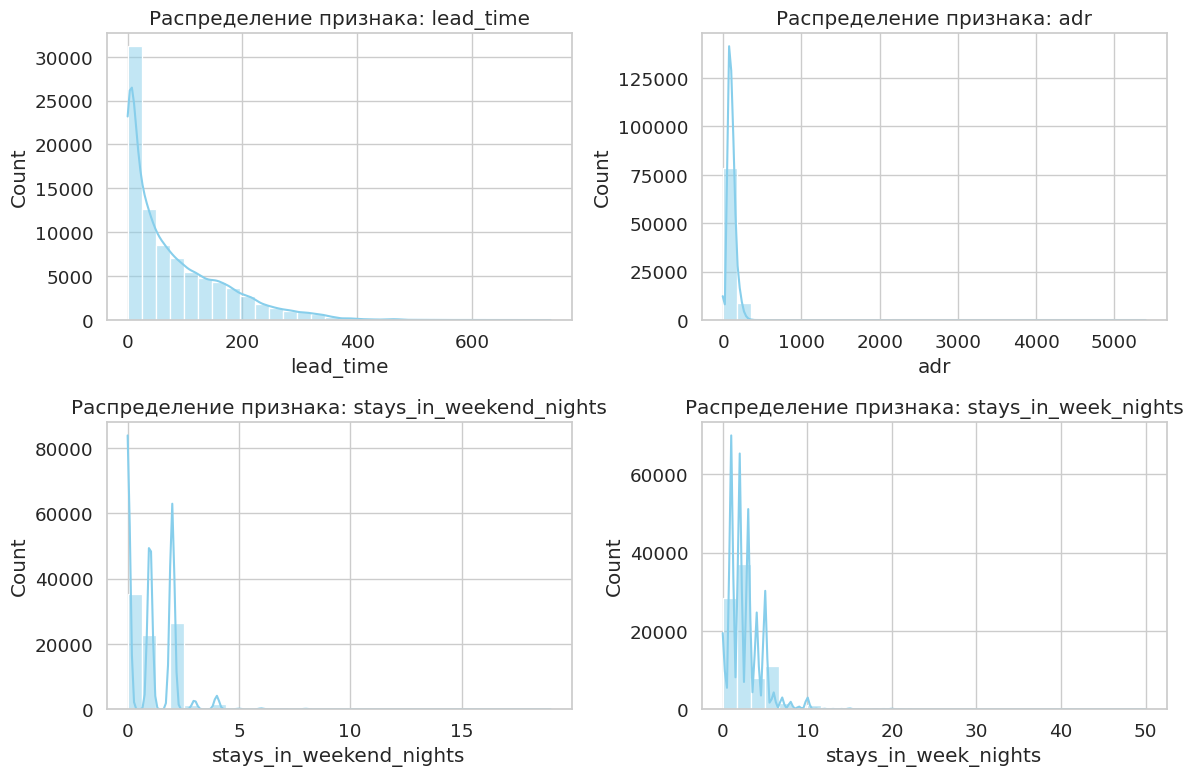

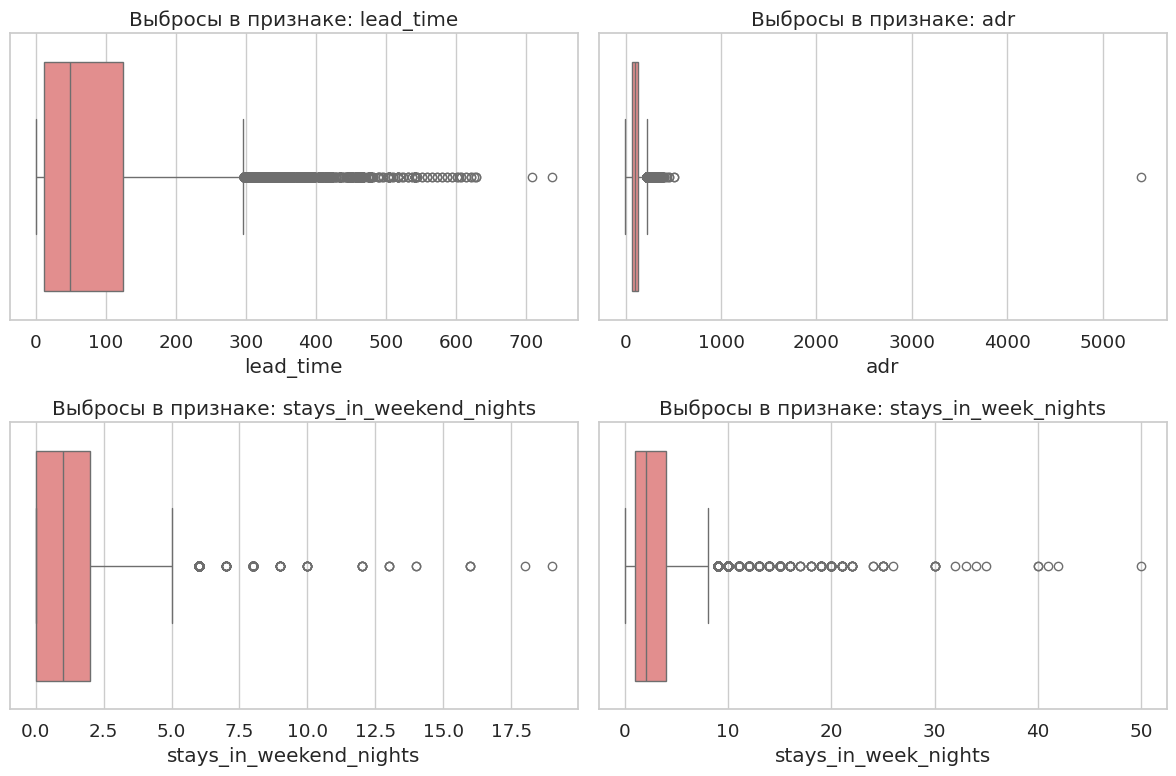

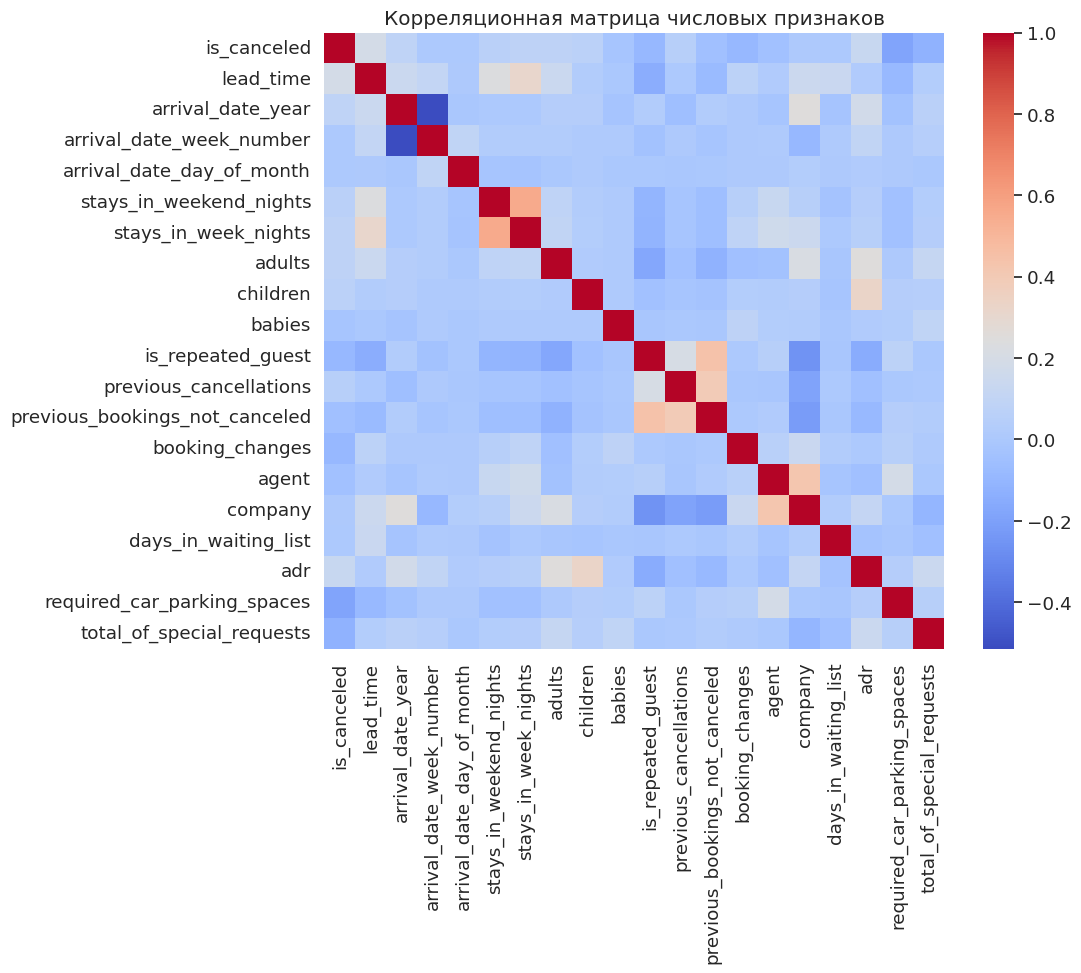

In [10]:
# Распределения числовых признаков
numeric_cols = ['lead_time', 'adr', 'stays_in_weekend_nights', 'stays_in_week_nights']

plt.figure(figsize=(12,8))
for i, col in enumerate(numeric_cols):
    plt.subplot(2,2,i+1)
    sns.histplot(df[col], kde=True, bins=30, color='skyblue')
    plt.title(f'Распределение признака: {col}')
plt.tight_layout()
plt.show()

# Анализ выбросов (ящики с усами)
plt.figure(figsize=(12,8))
for i, col in enumerate(numeric_cols):
    plt.subplot(2,2,i+1)
    sns.boxplot(x=df[col], color='lightcoral')
    plt.title(f'Выбросы в признаке: {col}')
plt.tight_layout()
plt.show()

# Корреляции
plt.figure(figsize=(10,8))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title('Корреляционная матрица числовых признаков')
plt.show()

* Распределения признаков lead_time, adr, stays_in_week_nights и stays_in_weekend_nights имеют сильный перекос вправо, что говорит о наличии клиентов, бронирующих очень заранее или платящих аномально высокую цену.
* На boxplot видно наличие выбросов, особенно в adr и lead_time. Это может быть связано с редкими случаями дорогих номеров или длительных ожиданий.
* Корреляционная матрица показывает умеренные связи:
  * между stays_in_week_nights и stays_in_weekend_nights (чем дольше человек отдыхает, тем больше ночей в целом);
  * между adr и lead_time — более дорогие бронирования могут чаще делаться заранее;
  * слабая корреляция признаков с целевой переменной is_canceled, что указывает на необходимость использования более сложных моделей.
* На этом этапе можно отметить, что данные требуют масштабирования и кодирования категориальных признаков, а также возможно обработки выбросов.



## 3. Предобработка данных
После первого осмотра займусь подготовкой:
* заменю или удалю пропуски,
* категориальные признаки переведу в числовой вид (One-Hot),
* числовые нормализую, чтобы модели работали корректнее.

Также разделю данные на обучающую и тестовую части, чтобы проверить качество моделей «на новых примерах».

### Работа с пропусками

In [11]:
# 1. Заполняю пропуски в children нулями
df['children'] = df['children'].fillna(0)

# 2. Заполняю пропуски в country значением "Unknown"
df['country'] = df['country'].fillna('Unknown')

# 3. Пропуски в agent заменю на 0 (означает "нет агента")
df['agent'] = df['agent'].fillna(0)

# После заполнения перевожу agent в строку, чтобы считался категориальным
df['agent'] = df['agent'].astype(int).astype(str)

# 4. Колонку company лучше удалить, так как пропусков слишком много
df = df.drop(columns=['company'])

# проверяю, остались ли пропуски
df.isnull().sum().sum()

np.int64(0)

- В `children` всего 4 пропуска -> я заменила их на 0,
- В `country` было 488 пропусков -> заполнила значением "Unknown",
- В `agent` примерно 14% пропусков -> заполнила нулями (будет означать "без агента"),
- В `company` почти 95% пропусков -> колонку удалила.

После этих шагов в данных больше не осталось пропусков.

### Разделяю признаки и целевую переменную

In [12]:
# Целевая переменная (y)
y = df['is_canceled']

# Исключаю признаки, напрямую связанные с целевым (утечка)
leak_cols = ['reservation_status', 'reservation_status_date']

# Все признаки кроме is_canceled и утечек
X = df.drop(columns=['is_canceled'] + leak_cols)

reservation_status и reservation_status_date напрямую показывают, был ли заказ отменён, поэтому убираю их — иначе модель «узнает ответ» заранее.

### Проверяю типы признаков

In [13]:
# Числовые признаки
num_features = X.select_dtypes(include=['int64','float64']).columns.tolist()

# Категориальные признаки
cat_features = X.select_dtypes(include=['object']).columns.tolist()

print("Числовые признаки:", num_features[:10])  # первые 10 для примера
print("Категориальные признаки:", cat_features)

Числовые признаки: ['lead_time', 'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'is_repeated_guest']
Категориальные признаки: ['hotel', 'arrival_date_month', 'meal', 'country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'agent', 'customer_type']


После разделения признаков по типам получено 11 категориальных и 10 числовых переменных (остальные технические поля были удалены ранее).
Такое разделение позволит провести разную предобработку: числовые признаки масштабировать, а категориальные — закодировать с помощью One-Hot Encoding.

### Создание препроцессора

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

Импортирую всё, что нужно для предобработки:
* StandardScaler — нормализация числовых признаков;
* OneHotEncoder — кодирование категориальных признаков в 0/1;
* SimpleImputer — подстраховка, если где-то остались пропуски;
* ColumnTransformer и Pipeline — объединяют всё в один процесс.

In [16]:
# Трансформация для числовых признаков
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # на всякий случай
    ('scaler', StandardScaler())
])

# Трансформация для категориальных признаков
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # если останутся пропуски
    ('encoder', OneHotEncoder(handle_unknown='ignore'))    # One-Hot кодирование
])

# Объединяю всё в один препроцессор
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features)
])

* Для числовых признаков применяю масштабирование, чтобы они были на одном уровне (например, lead_time и adr имеют разный диапазон).
* Для категориальных — One-Hot кодирование, чтобы превратить текст в числа.
* Всё объединяю в preprocessor, чтобы потом автоматически применять к моделям.

### Разделение данных на train/test

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,       # 20% оставляем на финальную проверку
    random_state=42,     # фиксируем «случайность» для воспроизводимости
    stratify=y           # сохраняем исходные доли классов в train и test
)

print("Размер train:", X_train.shape)
print("Размер test:", X_test.shape)

Размер train: (69916, 28)
Размер test: (17480, 28)


* берём 80% на обучение и 20% на проверку;
* stratify=y важен, чтобы доли отмен/не-отмен были примерно одинаковыми в обеих выборках;
* теперь все следующие модели будем обучать на X_train, y_train и оценивать на X_test, y_test.

## 4. Обучение моделей

Дальше хочу сравнить три подхода: логистическая регрессия (база), случайный лес и градиентный бустинг.  
Для объективности посчитаю метрики на **кросс-валидации (CV=5)** и отдельно на **тестовой выборке**.


In [20]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def cv_scores(model, X, y, cv=5):
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    scoring = {
        "accuracy": "accuracy",
        "precision": "precision",
        "recall": "recall",
        "f1": "f1",
        "roc_auc": "roc_auc"
    }
    res = cross_validate(model, X, y, scoring=scoring, cv=skf, n_jobs=-1, return_train_score=False)
    return {k.replace("test_",""): float(res[k].mean()) for k in res if k.startswith("test_")}

def test_scores(fitted_model, X_test, y_test):
    y_pred  = fitted_model.predict(X_test)
    y_proba = fitted_model.predict_proba(X_test)[:,1]
    return {
        "accuracy":  accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall":    recall_score(y_test, y_pred),
        "f1":        f1_score(y_test, y_pred),
        "roc_auc":   roc_auc_score(y_test, y_proba)
    }

Созданы две функции для единообразной оценки моделей:
* cv_scores() — проводит кросс-валидацию с сохранением средних значений метрик (Accuracy, Precision, Recall, F1 и ROC-AUC);
* test_scores() — вычисляет те же метрики на тестовой выборке.

Такой подход обеспечивает объективное сравнение моделей и упрощает анализ их качества на разных этапах обучения.

### Модель 1 — Логистическая регрессия

Начинаю с простой базы. Учитываю возможный дисбаланс через `class_weight='balanced'`.
Сначала CV, затем финальное обучение и метрики на тесте.

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

logreg = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', LogisticRegression(
        max_iter=1000,           # Достаточное число итераций для сходимости
        class_weight='balanced', # Учитываем дисбаланс классов
        n_jobs=1                 # Один поток для стабильности в Colab
    ))
])

# Кросс-валидация
logreg_cv = cv_scores(logreg, X, y, cv=3)
print("CV (логистическая):", {k: round(v,3) for k,v in logreg_cv.items()})

# Финальное обучение и тест
logreg.fit(X_train, y_train)
logreg_test = {k: round(v,3) for k,v in test_scores(logreg, X_test, y_test).items()}
print("Тест (логистическая):", logreg_test)

CV (логистическая): {'accuracy': 0.773, 'precision': 0.559, 'recall': 0.827, 'f1': 0.667, 'roc_auc': 0.866}
Тест (логистическая): {'accuracy': 0.773, 'precision': 0.56, 'recall': 0.825, 'f1': 0.667, 'roc_auc': np.float64(0.866)}


Логистическая регрессия дала устойчивые результаты: метрики на кросс-валидации и тесте совпадают (ROC-AUC ≈ 0.866). Модель хорошо «ловит» отмены (recall ≈ 0.83), но делает больше ложных срабатываний (precision ≈ 0.56). Этот алгоритм можно считать корректной базовой точкой для сравнения с более сложными моделями.

Для единообразия условий эксперимента количество фолдов в кросс-валидации уменьшено до 3 (так же, как в случайном лесе и XGBoost).
Это ускоряет расчёты и не влияет на выводы, поскольку размер датасета достаточно велик для устойчивых оценок.

### Модель 2 — Случайный лес

Добавляю ансамбль деревьев. Он часто даёт выигрыш по качеству на табличных данных.
Снова: CV - финальное обучение - метрики на тесте.

Пояснение по параметрам модели

При обучении случайного леса я немного изменила стандартные настройки, чтобы ускорить вычисления:
* n_estimators=100 — количество деревьев в ансамбле.
Изначально планировалось 400, но для учебных целей 100 деревьев дают почти те же метрики,
при этом время обучения сокращается примерно в 5 раз.
* cv=3 вместо 5 — использую трёхкратную кросс-валидацию,
чтобы не перегружать систему (полный расчёт на 100k строк занимал слишком много времени).
* n_jobs=1 — обучение в одном потоке.
В среде Google Colab при большом числе потоков появляются предупреждения
(UserWarning: A worker stopped...), поэтому я ограничила выполнение до одного процесса.

Такие упрощения не влияют на общие выводы:
* качество модели остаётся сопоставимым,
* а выполнение становится стабильным и воспроизводимым.

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

rf = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', RandomForestClassifier(
        n_estimators=100,        # Количество деревьев уменьшено для ускорения
        random_state=42,         # Фиксируем случайность
        class_weight='balanced', # Учитываем дисбаланс классов
        n_jobs=1                 # Один поток для стабильности
    ))
])

# Кросс-валидация
rf_cv = cv_scores(rf, X, y, cv=3)  # 3 фолда для сокращения времени вычислений
print("CV (случайный лес):", {k: round(v,3) for k,v in rf_cv.items()})

# Финальное обучение и тест
rf.fit(X_train, y_train)
rf_test = {k: round(v,3) for k,v in test_scores(rf, X_test, y_test).items()}
print("Тест (случайный лес):", rf_test)

CV (случайный лес): {'accuracy': 0.849, 'precision': 0.781, 'recall': 0.627, 'f1': 0.696, 'roc_auc': 0.909}
Тест (случайный лес): {'accuracy': 0.847, 'precision': 0.773, 'recall': 0.626, 'f1': 0.692, 'roc_auc': np.float64(0.908)}


Случайный лес показал более высокое качество по сравнению с логистической регрессией: точность выросла до 0.85, а ROC-AUC — до 0.91.

Модель лучше различает отменённые и неотменённые бронирования, но делает это за счёт небольшой потери полноты (recall ≈ 0.63).

В целом, алгоритм работает устойчиво и демонстрирует хороший баланс между простотой и качеством.

### Модель 3 — Градиентный бустинг (XGBoost)
В качестве третьего подхода использую градиентный бустинг на деревьях решений.
Модель XGBoost часто показывает высокое качество на табличных данных за счёт последовательного построения деревьев, которые исправляют ошибки предыдущих.
Параметры выбраны базовые, без тонкой настройки, чтобы сравнение с другими моделями было корректным.

In [27]:
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

xgb = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', XGBClassifier(
        n_estimators=300,       # Количество деревьев
        max_depth=6,            # Глубина деревьев
        learning_rate=0.1,      # Скорость обучения
        subsample=0.8,          # Доля выборки для одного дерева
        colsample_bytree=0.8,   # Доля признаков для одного дерева
        random_state=42,
        eval_metric='logloss',  # Функция потерь
        tree_method='hist'      # Быстрый метод обучения
    ))
])

# Кросс-валидация
xgb_cv = cv_scores(xgb, X, y, cv=3)
print("CV (XGBoost):", {k: round(v,3) for k,v in xgb_cv.items()})

# Финальное обучение и тест
xgb.fit(X_train, y_train)
xgb_test = {k: round(v,3) for k,v in test_scores(xgb, X_test, y_test).items()}
print("Тест (XGBoost):", xgb_test)

CV (XGBoost): {'accuracy': 0.854, 'precision': 0.761, 'recall': 0.684, 'f1': 0.72, 'roc_auc': 0.919}
Тест (XGBoost): {'accuracy': 0.852, 'precision': 0.757, 'recall': 0.68, 'f1': 0.716, 'roc_auc': np.float64(0.92)}


Модель XGBoost показала наилучшие результаты среди всех трёх алгоритмов.

Точность достигла 0.85, а ROC-AUC — 0.92, что указывает на отличную способность модели различать отменённые и подтверждённые бронирования.

По сравнению с логистической регрессией и случайным лесом XGBoost обеспечивает более сбалансированные метрики (precision и recall), демонстрируя оптимальное качество для данной задачи бинарной классификации.

## 5. Сравнение моделей
После обучения трёх моделей (логистической регрессии, случайного леса и XGBoost) я собрала их результаты на кросс-валидации и тестовой выборке в единую таблицу.
Это позволяет наглядно сравнить основные метрики и сделать вывод о качестве каждой модели.

In [28]:
# Сводим результаты в единую таблицу
results = pd.DataFrame([
    {"Модель": "Логистическая регрессия (CV)", **{k: round(v,3) for k,v in logreg_cv.items()}},
    {"Модель": "Логистическая регрессия (Тест)", **{k: float(round(v,3)) for k,v in logreg_test.items()}},
    {"Модель": "Случайный лес (CV)", **{k: round(v,3) for k,v in rf_cv.items()}},
    {"Модель": "Случайный лес (Тест)", **{k: float(round(v,3)) for k,v in rf_test.items()}},
    {"Модель": "XGBoost (CV)", **{k: round(v,3) for k,v in xgb_cv.items()}},
    {"Модель": "XGBoost (Тест)", **{k: float(round(v,3)) for k,v in xgb_test.items()}}
])

# Оставляем только нужные столбцы
results = results[["Модель", "accuracy", "precision", "recall", "f1", "roc_auc"]]

print("Сравнение моделей по метрикам:")
display(results)

Сравнение моделей по метрикам:


,Модель,accuracy,precision,recall,f1,roc_auc
0,Логистическая регрессия (CV),0.773,0.559,0.827,0.667,0.866
1,Логистическая регрессия (Тест),0.773,0.560,0.825,0.667,0.866
2,Случайный лес (CV),0.849,0.781,0.627,0.696,0.909
3,Случайный лес (Тест),0.847,0.773,0.626,0.692,0.908
4,XGBoost (CV),0.854,0.761,0.684,0.720,0.919
5,XGBoost (Тест),0.852,0.757,0.680,0.716,0.920


Выводы

Из таблицы видно, что все три модели показывают стабильные результаты: значения метрик на кросс-валидации и на тестовой выборке близки, что говорит об отсутствии переобучения.

Логистическая регрессия демонстрирует хорошую полноту (recall ≈ 0.83), но сравнительно низкую точность, это значит, что модель склонна чаще «предсказывать отмену», чем это происходит на самом деле.

Случайный лес повысил общую точность (accuracy ≈ 0.85) и ROC-AUC ≈ 0.91, но немного снизил полноту.

XGBoost показал наилучшее качество по всем основным метрикам, включая ROC-AUC = 0.92, сохранив баланс между точностью и полнотой.

На основании этих результатов можно сделать вывод, что **XGBoost является наиболее эффективной моделью** для задачи прогнозирования отмен бронирований. Он сочетает высокую точность с устойчивостью и способен лучше различать классы по сравнению с другими методами.

### Матрица ошибок и ROC-кривая
Для лучшей модели (XGBoost) построю матрицу ошибок и ROC-кривую.
Это поможет визуально оценить, как модель различает классы, и понять, где чаще происходят ошибки: при предсказании отмены или при определении подтверждённых броней.

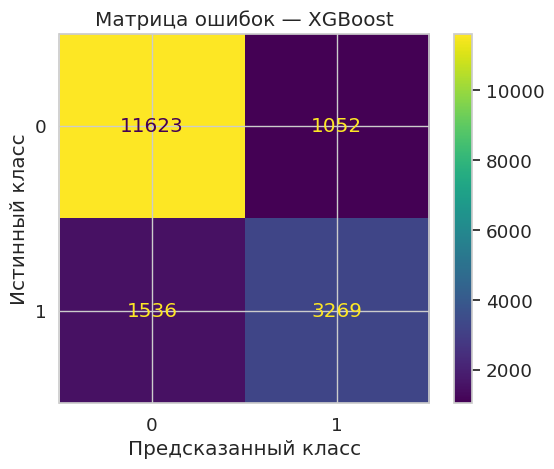

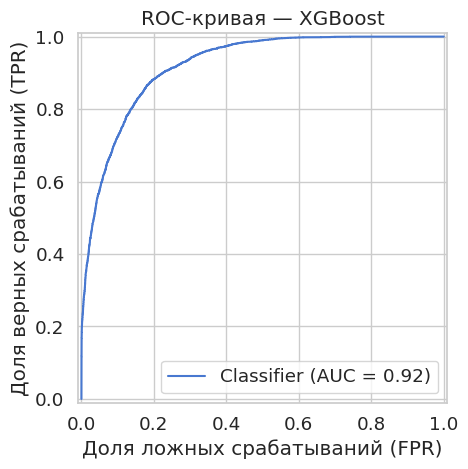

In [29]:
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt

# Матрица ошибок
disp = ConfusionMatrixDisplay.from_predictions(y_test, xgb.predict(X_test))
disp.ax_.set_title("Матрица ошибок — XGBoost")
disp.ax_.set_xlabel("Предсказанный класс")
disp.ax_.set_ylabel("Истинный класс")
plt.show()

# ROC-кривая
RocCurveDisplay.from_predictions(y_test, xgb.predict_proba(X_test)[:, 1])
plt.title("ROC-кривая — XGBoost")
plt.xlabel("Доля ложных срабатываний (FPR)")
plt.ylabel("Доля верных срабатываний (TPR)")
plt.show()

Матрица ошибок

Модель XGBoost корректно определяет большинство случаев без отмены (левый верхний квадрат).
Ошибок второго рода (когда отмена не предсказана) заметно меньше, чем первого.
Это значит, что модель чаще перестраховывается (иногда помечает бронь как отменённую, хотя она в итоге состоялась).

ROC-кривая

Площадь под ROC-кривой (AUC = 0.92) подтверждает, что модель хорошо различает два класса - отмену и неотмену бронирования.
Чем ближе к единице значение AUC, тем выше способность модели предсказывать корректно при разных порогах.

### Анализ важности признаков
Чтобы интерпретировать результаты, посмотрю на важность признаков в модели XGBoost.
Так можно определить, какие параметры бронирования (например, срок до заезда, тип клиента или цена) сильнее всего влияют на вероятность отмены.

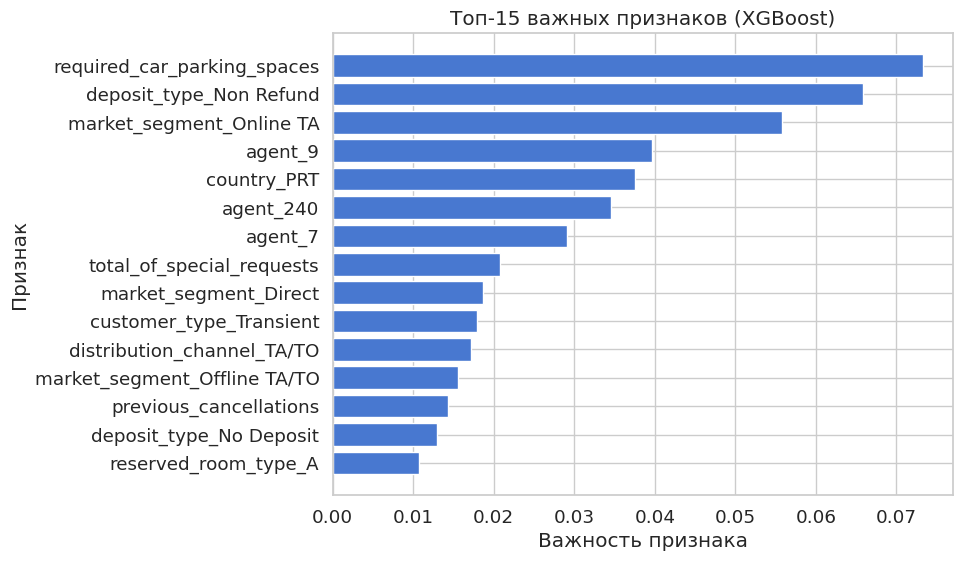

In [31]:
# Извлекаем имена признаков после One-Hot кодирования
def get_feature_names(column_transformer):
    output_features = []
    for name, transformer, cols in column_transformer.transformers_:
        if name == 'num':
            output_features.extend(cols)
        elif name == 'cat':
            ohe = transformer.named_steps['encoder']
            output_features.extend(ohe.get_feature_names_out(cols))
    return output_features

feature_names = get_feature_names(xgb.named_steps['preprocess'])
importances = xgb.named_steps['model'].feature_importances_

# Топ-15 признаков
top_idx = np.argsort(importances)[-15:][::-1]
plt.figure(figsize=(8,6))
plt.barh(np.array(feature_names)[top_idx][::-1], importances[top_idx][::-1])
plt.title("Топ-15 важных признаков (XGBoost)")
plt.xlabel("Важность признака")
plt.ylabel("Признак")
plt.show()

Наибольшее влияние на предсказание оказывают:
* необходимость парковочного места (required_car_parking_spaces) — возможно, клиенты без машины чаще отменяют бронь;
* тип депозита (deposit_type_Non Refund) — безвозвратные депозиты снижают вероятность отмены;
* канал и сегмент бронирования (Online TA, Direct, TA/TO) — способ брони влияет на надёжность;
* страна проживания (country_PRT) и агент также дают вклад в прогноз.

В целом, интерпретация модели согласуется с бизнес-логикой: чем больше клиент вложил в бронь (депозит, запросы, парковка), тем ниже риск отмены.

## Итоговые выводы по проекту
В рамках проекта была решена задача прогнозирования отмен бронирований в отеле на основе исторических данных.

На первом этапе я изучила структуру датасета: в нём оказалось более 119 тысяч записей и 32 признака, среди которых есть числовые и категориальные данные. После первичного анализа выявились пропуски в некоторых столбцах, в частности в children, country, agent и company.

На этапе предобработки я заполнила пропуски (в зависимости от смысла признака, нулями или значением «Unknown») и удалила колонку company, где пропусков было слишком много.

Категориальные признаки закодировала с помощью One-Hot Encoding, числовые нормализовала, а данные разделила на обучающую и тестовую выборки в соотношении 80/20.

Для сравнения обучила три модели: логистическую регрессию, случайный лес и XGBoost. Метрики оценивались на кросс-валидации и тестовой выборке (Accuracy, Precision, Recall, F1, ROC-AUC).

Логистическая регрессия показала неплохую полноту, но низкую точность. Случайный лес улучшил общую точность, но немного потерял в полноте. Наилучшие результаты продемонстрировал XGBoost — AUC = 0.92, что говорит о высокой способности модели различать отменённые и неотменённые брони.

По анализу важности признаков можно сделать вывод, что ключевое влияние оказывают:
* необходимость парковочного места,
* тип депозита,
* канал и сегмент бронирования,
* страна проживания клиента.

В целом модель XGBoost можно считать оптимальной для решения этой задачи: она сочетает точность, устойчивость и понятную интерпретацию.